In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./Data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, make_scorer

#%matplotlib inline
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

./Data\test.csv
./Data\train.csv


In [2]:
# Reading input files

df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

print(df_train.shape)
print(df_test.shape)

(32561, 16)
(16281, 15)


In [3]:
#FMP - converting sex cariable to numeric
def sex2num(sex):
    if sex.strip() == 'Male':
        return 1 
    else: 
        return 0

df_train['sex'] = df_train['sex'].apply(sex2num)
df_test['sex'] = df_test['sex'].apply(sex2num)

#FMP - simplifying marital status
def simplify_marital_status(maritalstatus):
    if maritalstatus.strip().startswith('Married'):
        return 1 
    else: 
        return 0
    
df_train['marital-status'] = df_train['marital-status'].apply(simplify_marital_status)
df_test['marital-status'] = df_test['marital-status'].apply(simplify_marital_status)

def simplify_hours_per_week(hours):
    if hours >= 40:
        return 1 
    else: 
        return 0

df_train['hours-per-week'] = df_train['hours-per-week'].apply(simplify_hours_per_week)
df_test['hours-per-week'] = df_test['hours-per-week'].apply(simplify_hours_per_week)

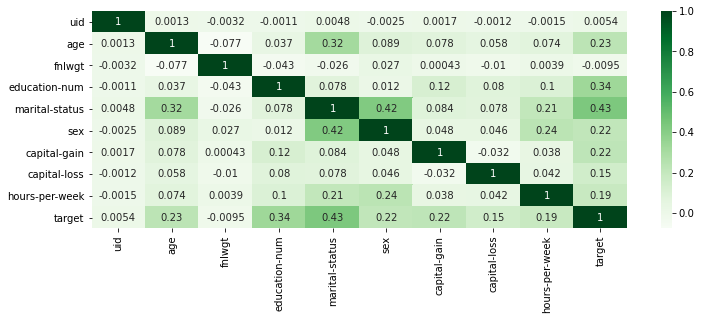

In [4]:
numeric_features = df_train.select_dtypes(include=np.number).columns.tolist()

#Check correlation
plt.figure(figsize=(12, 4))
sns.heatmap(df_train[numeric_features].corr(), annot=True, cmap='Greens')

In [5]:
# FMP - concatenating train and test into a new dataframe (df)
df = pd.concat([df_train, df_test], sort=True)

#FMP - droping some unneeded variables
df.drop(columns=['fnlwgt', 'education'], axis=1, inplace=True)

# FMP - adding the target column to the test dataset (filled with NaN)
df_test['target'] = np.nan

def simplify_native_country(country):
    country = country.strip()
    if country == 'United-States':
        return 'USA' 
    elif country in {'Mexico', 'Puerto-Rico', 'El-Salvador','Dominican-Republic','Guatemala', 'Columbia', 'Nicaragua', 'Peru' 'Honduras'}: 
        return 'LatAm' 
    else:
        return 'Other'

#df['native-country'] = df['native-country'].apply(simplify_native_country)

print(df.shape)

(48842, 14)


In [6]:
df_tmp = df.loc[df['target'].notna()] \
        .groupby(['education-num'])['target'] \
        .agg(['mean', 'std']) \
        .rename(columns={'mean': 'target_mean', 'std': 'target_std'}) \
        .fillna(0.0) \
        .reset_index()

df_tmp.head(100)

,education-num,target_mean,target_std
0,1.0,0.000000,0.000000
1,2.0,0.035714,0.186132
2,3.0,0.048048,0.214190
3,4.0,0.061920,0.241196
4,5.0,0.052529,0.223309
5,6.0,0.066452,0.249205
6,7.0,0.051064,0.220222
7,8.0,0.076212,0.265645
8,9.0,0.159509,0.366167
9,10.0,0.190235,0.392513


In [7]:
#FMP - merging df with the pivot table to add target mean and target std columns
df = pd.merge(df, df_tmp, how='left', on=['education-num'])

df = pd.get_dummies(
    df, 
    columns=[c for c in df.columns if df[c].dtype == 'object']
)

df.shape

(48842, 88)

In [8]:
our_x_train = df.loc[df['target'].notna()].drop(columns=['target'])
our_y_train = df.loc[df['target'].notna()]['target']
our_x_test = df.loc[df['target'].isna()].drop(columns=['target'])
our_y_test = df.loc[df['target'].isna()]['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(our_x_train,
                                                    our_y_train,
                                                    test_size=0.33,
                                                    random_state=17)

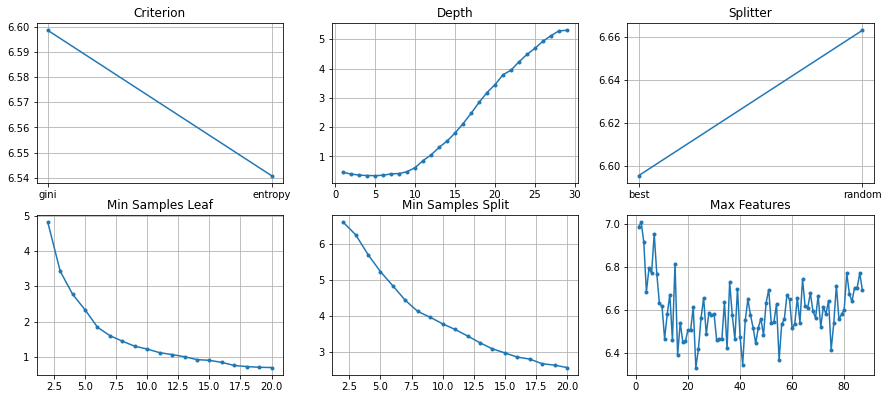

In [10]:
plt.figure(figsize=(15, 10))

#critetion
plt.subplot(3, 3, 1)

feature_param = ['gini', 'entropy']
scores = []

for feature in feature_param:
    clf = DecisionTreeClassifier(criterion=feature)
    clf.fit(X_train, y_train)
    scores.append(log_loss(y_test, clf.predict_proba(X_test)[:, 1]))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Criterion')
plt.grid()

#max_depth
plt.subplot(3, 3, 2)
max_depth_check = range(1, 30)
scores = []
for depth in max_depth_check:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    scores.append(log_loss(y_test, clf.predict_proba(X_test)[:, 1]))
plt.plot(max_depth_check, scores, '.-')
plt.axis('tight')
plt.title('Depth')
plt.grid()

#Splitter
plt.subplot(3, 3, 3)
feature_param = ['best', 'random']
scores = []
for feature in feature_param:
    clf = DecisionTreeClassifier(splitter=feature)
    clf.fit(X_train, y_train)
    scores.append(log_loss(y_test, clf.predict_proba(X_test)[:, 1]))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Splitter')
plt.grid()

#Min Samples Leaf
plt.subplot(3, 3, 4)
feature_param = range(2, 21)
scores = []
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_leaf=feature)
    clf.fit(X_train, y_train)
    scores.append(log_loss(y_test, clf.predict_proba(X_test)[:, 1]))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Leaf')
plt.grid()

#Min Samples Split
plt.subplot(3, 3, 5)
feature_param = range(2, 21)
scores = []
for feature in feature_param:
    clf = DecisionTreeClassifier(min_samples_split=feature)
    clf.fit(X_train, y_train)
    scores.append(log_loss(y_test, clf.predict_proba(X_test)[:, 1]))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid()

#max_features
plt.subplot(3, 3, 6)
feature_param = range(1, df.shape[1])
scores = []
for feature in feature_param:
    clf = DecisionTreeClassifier(max_features=feature)
    clf.fit(X_train, y_train)
    scores.append(log_loss(y_test, clf.predict_proba(X_test)[:, 1]))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Features')
plt.grid()

In [ ]:
model = DecisionTreeClassifier(criterion='gini',
                               splitter='best',
                               max_depth=10,
                               max_features=5,
                               min_samples_split=40,
                               min_samples_leaf=12)
parameter_grid = {
    'criterion' : ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(5, 15),
    'max_features': range(1, 9),
    'min_samples_split': [35, 40, 45, 50],
    'min_samples_leaf': [5, 10, 15, 20],
}
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=5, scoring=LogLoss)
grid_search.fit(X_train, y_train)

In [ ]:
print(f'Best score: {grid_search.best_score_}')
print(f'Best parameters: {grid_search.best_params_}')